# RBF SVR

Haytham Mohamed

INFS 890 - Spring 2020

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.4f}'.format

Set this flag to True if you're using reduction feature using FCA, otherwise set it to False

In [13]:
# 1- read data file
# 1- read processed file
home_dir = '/Users/hmohamed/github/data-research-spring2020/sock-shop'
file_dir = home_dir + '/processed-data/'

#data_file = 'orders_flow_data.csv'   # raw data as is
#data_file = 'order_flow_cleanup_data.csv'
data_file = 'order_flow_normalized_data.csv'
#data_file = 'order_flow_standardized_data.csv'
#data_file = 'order_flow_factored_data.csv'


SCALE_TARGETS = True

test_split = 0.1

In [14]:
def read_df(file_dir, data_file, timeseries=True):
    df = pd.read_csv(file_dir + data_file)
    if timeseries:
        df = to_time_series(df)
    return df

def to_time_series(df, index_col_name='date'):
    df[index_col_name] = pd.to_datetime(df[index_col_name])
    df.set_index(index_col_name, inplace=True)
    df.sort_index(inplace=True)
    return df

def merge(df, series):
    return pd.merge_asof(df, series, left_index=True, right_index=True, tolerance=pd.Timedelta('1 second')).bfill()    


In [15]:
data = read_df(file_dir, data_file, True)
data = data.reset_index(drop=True)
data.head(5)

front-end_cpu_use  orders_cpu_use  orders-db_cpu_use  user_cpu_use  \
0             0.0700          0.0200             0.0100        0.0200   
1             0.0600          0.0300             0.0100        0.0200   
2             0.2100          0.0600             0.0200        0.0500   
3             0.2200          0.0600             0.0200        0.0600   
4             0.2100          0.0600             0.0100        0.0500   

   user-db_cpu_use  shipping_cpu_use  payment_cpu_use  carts_cpu_use  \
0           0.0200            0.0100           0.0100         0.1200   
1           0.0200            0.0100           0.0100         0.1400   
2           0.0300            0.0200           0.0100         0.2400   
3           0.0400            0.0200           0.0100         0.2100   
4           0.0400            0.0200           0.0100         0.1500   

   carts-db_cpu_use  front-end_pods  orders_pods  user_pods  shipping_pods  \
0            0.1600          1.0000       1.0000     1.0000         1.0000   
1            0.1700          1.0000       1.0000     1.0000         1.0000   
2            0.6600          1.0000       1.0000     1.0000         1.0000   
3            0.6600          1.0000       1.0000     1.0000         1.0000   
4            0.6600          1.0000       1.0000     1.0000         1.0000   

   payment_pods  carts_pods  nodes_cpu_use  orders_req  orders_ltcy  
0        1.0000      1.0000         1.1800      0.4000       0.4000  
1        1.0000      1.0000         1.1800      0.4400       0.3900  
2        1.0000      1.0000         1.8400      1.5800       0.4200  
3        1.0000      1.0000         1.8300      1.5800       0.4100  
4        1.0000      1.0000         1.7500      1.4900       0.3900

In [16]:
data.shape

(3175, 18)

In [17]:
targets = data['orders_ltcy']
inputs = data.drop(['orders_ltcy'], axis=1)

n_features = inputs.values.shape[1]
print("there are {} features".format(n_features))


there are 17 features


In [18]:
# scale targets for better convergence
if SCALE_TARGETS:
    y_scaler =  MinMaxScaler()
    targets = y_scaler.fit_transform(targets.values.reshape(-1,1))

In [19]:
x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=test_split, shuffle=False, random_state=365)

if 1 == 0:
    # for better convergence and result scale target to values between 0 - 1
    y_train_max = y_train.max()
    y_test_max = y_test.max()

    y_train = y_train / y_train_max
    y_test = y_test / y_test_max


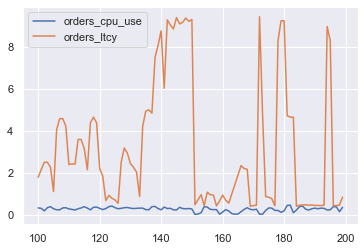

In [20]:
# plot cpu vs latency 
plt.plot(data['orders_cpu_use'][100:200], label='orders_cpu_use')
plt.plot(data['orders_ltcy'][100:200], label='orders_ltcy')
plt.legend()
plt.show()

#ax = sns.regplot(x=data['orders_cpu_use'], y=data['orders_ltcy'], color='g')


# Model

In [21]:
#lasso = LassoCV(fit_intercept=False,n_jobs=-1,random_state=0,selection='random',positive=False,cv=10)
#sfm1 = SelectFromModel(lasso, threshold='0.01*mean')

rfr = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=20)
sfm = SelectFromModel(rfr, threshold='0.01*mean')

#sfm = SelectKBest(k=6)

#sfm = PCA(random_state=180)

# SVR
reg = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)

pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('selector', sfm),
    ('reg', reg)
])

kfold = KFold(n_splits=10, shuffle=True)

param_grid = {
    #'selector__threshold': [0.1, 0.05, 0.02, 0.001]  # with lasso
    'selector__threshold': ['1*mean', '0.8*mean', '0.6*mean', '0.3*mean', '0.1*mean','0.05*mean', '0.02*mean', '0.01*mean', '0.001*mean'] # with tree
    , 'selector__estimator__max_depth' : [20]
    , 'selector__estimator__n_estimators' : [40]
    # 'selector__n_components' : [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]   # with PCA
    ,'reg__C': [100]
    ,'reg__gamma': [0.1]
    ,'reg__epsilon': [0.1]
}

search = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=1, n_jobs=-1)

#scores = cross_val_score(pipe, x_train, y_train, cv=kfold, n_jobs=-1
        #, verbose=3, scoring='neg_mean_squared_error')



In [22]:
import sklearn 
print('sklearn version {}'.format(sklearn.__version__))

search.fit(x_train, y_train)

sklearn version 0.22.2.post1
Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   23.6s finished
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/feature_selection/_from_model.py:222: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator_.fit(X, y, **fit_params)
/opt/anaconda3/envs/infs890/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('selector',
                                        SelectFromModel(estimator=RandomForestRegressor(bootstrap=True,
                                                                                        ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features='auto',
                      

# Best Model

In [23]:
score = search.best_score_
print("Best CV test score = %0.4f:" % score)

params = search.best_params_
print("Best CV params = {}".format(params))

#print("")
all_training_scores = search.cv_results_
#print("\ncross_validation:\n", all_training_scores , "\n")

#print('mean train scores')
#print(all_training_scores['mean_train_score'])

#print('mean test scores')
#print(all_training_scores['mean_test_score'])


Best CV test score = -0.0546:
Best CV params = {'reg__C': 100, 'reg__epsilon': 0.1, 'reg__gamma': 0.1, 'selector__estimator__max_depth': 20, 'selector__estimator__n_estimators': 40, 'selector__threshold': '0.3*mean'}


# Features Selected

In [24]:
if 1 == 0:
    best_threshold = params['selector__threshold']
    best_max_depth = params['selector__estimator__max_depth']
    best_n_estimators = params['selector__estimator__n_estimators']

    select_model = RandomForestRegressor(n_jobs=-1, max_depth=best_max_depth, n_estimators=best_n_estimators)
    sfm = SelectFromModel(model, threshold=best_threshold)

    selectedFeatures = sfm.fit(x_train, y_train).transform(x_train)
    print('{} features selected'.format(selectedFeatures[1].shape[0]))

    feature_list = x_train.columns[sfm.get_support()]
    features = ''
    features = ', '.join(feature_list)
    #features

    reduced_x_train = x_train[feature_list]
    #reduced_x_train.head(2)
    print('')
    for feature in reduced_x_train.columns.values:
        print(feature)

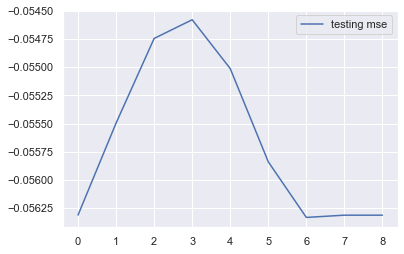

In [25]:
pdf = pd.DataFrame(all_training_scores['mean_test_score'], columns=['testing mse'])
pdf.plot()

# Training R2

In [26]:
y_train_hat = search.predict(x_train)

r2_train = metrics.r2_score(y_train, y_train_hat)
print('R2 (training) = {}'.format(r2_train))

print('Score (training) = {}'.format(search.score(x_train,y_train)))

R2 (training) = 0.5808915239728022
Score (training) = -0.049629039895797214


In [27]:
# validation mean_absolute_percentage_error
train_error =  np.abs(y_train - y_train_hat)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)


print("Model Result (mean - std of error - min - max): %.2f (%.2f) %.2f %.2f MSE" \
      % (mean_error, std_error, min_error, max_error))

Model Result (mean - std of error - min - max): 0.36 (0.24) 0.00 1.13 MSE


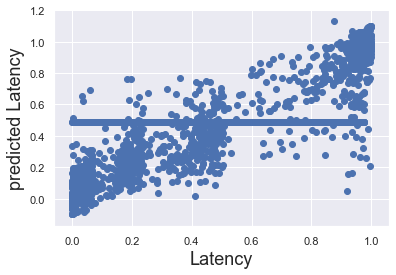

In [28]:
plt.scatter(y_train, y_train_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

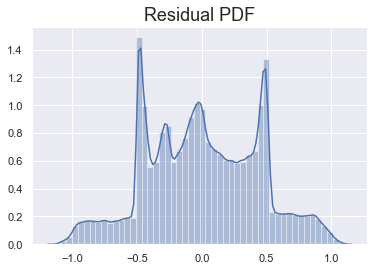

In [29]:
sns.distplot(y_train - y_train_hat)
plt.title('Residual PDF', size=18)

# Testing

In [30]:
y_test_hat = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

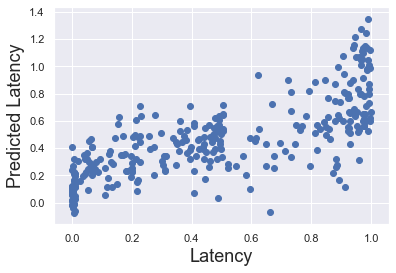

In [31]:
plt.scatter(y_test, y_test_hat)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

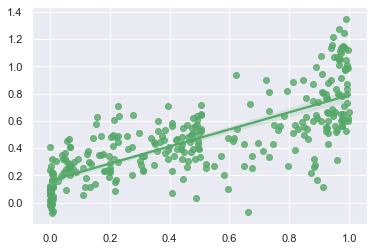

In [32]:
ax = sns.regplot(x=y_test, y=y_test_hat, color='g')

In [33]:
perf = pd.DataFrame(y_test_hat, columns=['prediction'])
perf['target'] = y_test
perf.head()

prediction  target
0     -0.0175  0.0016
1     -0.0730  0.0071
2     -0.0594  0.0093
3     -0.0393  0.0027
4      0.0188  0.0016

In [34]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

prediction  target  residual  difference%
0       -0.0175  0.0016   -0.0191   1,211.3700
1       -0.0730  0.0071   -0.0801   1,132.0922
2       -0.0594  0.0093   -0.0687     740.5540
3       -0.0393  0.0027   -0.0420   1,568.4203
4        0.0188  0.0016    0.0172   1,090.2109
..          ...     ...       ...          ...
313      0.8711  0.9945   -0.1234      12.4071
314      0.9912  0.9967   -0.0055       0.5564
315      0.7939  0.9945   -0.2006      20.1666
316      0.8971  0.9384   -0.0414       4.4066
317      1.1492  0.9780    0.1712      17.5082

[318 rows x 4 columns]

In [35]:
perf.describe()

prediction   target  residual  difference%
count    318.0000 318.0000  318.0000     318.0000
mean       0.4635   0.4823   -0.0188     865.2938
std        0.2981   0.3622    0.2357   5,247.3209
min       -0.0730   0.0005   -0.7979       0.1996
25%        0.2455   0.1302   -0.1617      17.2670
50%        0.4321   0.4585    0.0239      37.3329
75%        0.6237   0.8859    0.1461     172.5432
max        1.3505   1.0000    0.4813  85,243.9454

In [36]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

prediction  target  residual  difference%
46         0.12    0.12      0.00         0.20
292        0.98    0.99     -0.00         0.45
260        0.99    0.99     -0.00         0.45
314        0.99    1.00     -0.01         0.56
264        0.87    0.88     -0.01         0.76
240        0.98    0.99     -0.01         1.02
186        0.47    0.48     -0.01         1.08
78         0.51    0.50      0.01         1.57
109        0.46    0.47     -0.01         1.66
273        1.01    0.99      0.02         1.91
106        0.39    0.39     -0.01         1.97
76         0.31    0.30      0.01         2.24
210        0.41    0.40      0.01         2.36
118        0.43    0.44     -0.01         3.06
288        0.82    0.79      0.03         3.27
165        0.52    0.51      0.02         3.41
294        0.94    0.91      0.03         3.71
215        0.19    0.20     -0.01         4.11
316        0.90    0.94     -0.04         4.41
112        0.48    0.46      0.02         4.56
304        1.01    0.97      0.05         4.66
138        0.49    0.47      0.02         4.87
149        0.37    0.39     -0.02         4.96
271        0.88    0.93     -0.05         5.35
168        0.44    0.47     -0.02         5.36
147        0.50    0.47      0.03         5.48
266        1.04    0.99      0.06         5.64
307        0.92    0.97     -0.06         5.99
269        0.90    0.85      0.05         6.43
212        0.38    0.36      0.02         6.80
137        0.54    0.51      0.03         6.84
92         0.40    0.42     -0.03         6.89
105        0.53    0.49      0.04         7.33
148        0.40    0.44     -0.03         7.65
194        0.14    0.15     -0.01         7.71
108        0.46    0.42      0.03         7.85
141        0.34    0.31      0.02         7.93
299        1.05    0.97      0.08         8.24
268        0.72    0.67      0.06         8.36
262        0.67    0.73     -0.06         8.50
282        1.05    0.97      0.08         8.54
187        0.45    0.50     -0.04         8.75
293        0.89    0.81      0.07         9.03
80         0.46    0.42      0.04         9.10
219        0.28    0.30     -0.03         9.18
270        1.05    0.96      0.09         9.30
172        0.48    0.44      0.04         9.34
167        0.39    0.44     -0.04        10.02
88         0.77    0.85     -0.09        10.08
173        0.34    0.31      0.03        10.46
303        0.81    0.91     -0.10        11.03
162        0.34    0.31      0.03        11.08
261        0.81    0.73      0.08        11.12
32         0.22    0.20      0.02        11.32
301        1.07    0.96      0.11        11.40
281        1.00    0.89      0.11        12.02
222        0.80    0.91     -0.11        12.29
313        0.87    0.99     -0.12        12.41
308        1.12    1.00      0.13        12.70
171        0.43    0.49     -0.06        12.78
272        1.07    0.95      0.12        12.85
305        1.10    0.97      0.13        12.94
169        0.54    0.62     -0.08        12.99
193        0.83    0.96     -0.13        13.23
277        0.79    0.92     -0.13        14.06
296        1.11    0.97      0.14        14.75
300        1.14    0.99      0.15        14.93
87         0.57    0.49      0.07        14.94
45         0.11    0.13     -0.02        14.95
278        0.75    0.88     -0.13        15.10
198        0.55    0.48      0.07        15.58
140        0.23    0.20      0.03        15.65
286        0.83    0.99     -0.16        15.87
196        0.56    0.49      0.08        15.94
275        1.14    0.97      0.16        16.52
312        1.14    0.98      0.16        16.62
289        1.14    0.97      0.16        16.73
283        0.80    0.96     -0.16        16.88
279        0.77    0.92     -0.16        17.02
151        0.34    0.42     -0.07        17.27
285        0.77    0.93     -0.16        17.27
302        0.74    0.90     -0.16        17.38
213        0.37    0.45     -0.08        17.40
317        1.15    0.98      0.17        17.51
291       

# *** Prediction Accuracy

In [37]:
r2_test = metrics.r2_score(y_test, y_test_hat)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.5738982492839508


In [38]:
print(np.sqrt(mean_squared_error(y_test,y_test_hat)))

0.23607772909565478
